# **Covid-19 detection on X-ray Images**


Our final project seeks to use some deep neural networks to detect Covid-19 through X-ray images of patients. In this project, we aim to test different popular image recognition models on the covid-19 detection dataset on kaggle, with transfer learning technique. 

We found the covid-19 x-ray dataset from Kaggle with the following link: https://www.kaggle.com/datasets/manishkc06/covid19-detection.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from PIL import Image
import os
import torch.nn as nn

In [ ]:
df = pd.read_csv('drive/MyDrive/project-forceofwill/archive/Training_set_covid.csv')
train_img_path = 'drive/MyDrive/project-forceofwill/archive/train/train'

In [ ]:
#show sample image

from tqdm import tqdm

imgs = []
labels = []
for i in tqdm(range(len(df['filename']))):
    img = Image.open(os.path.join(train_img_path, df['filename'][i]))
    imgs.append(img)
    labels.append(df['label'][i])

100%|██████████| 3479/3479 [26:47<00:00,  2.16it/s]


class CovidData(Dataset): Custom PyTorch Dataset class for loading the Covid-19 dataset.

    Parameters:
            imgs (list): A list of loaded images.
            labels (list): A list of labels corresponding to each image.
            transform (callable): A function/transform to apply to the images.

    Returns:
            tuple: A tuple containing the transformed image and its corresponding label.

    Training set transformations include resizing the images, random horizontal flipping, random perspective changes, converting to a tensor, and normalizing the pixel values. The testing set transformations only resize and normalize the pixel values.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms, models, datasets
from sklearn.metrics import classification_report


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CovidData(Dataset):
    def __init__(self, imgs, labels, transform):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.transform(self.imgs[idx]), torch.tensor(self.labels[idx])

train_x, test_x, train_y, test_y = train_test_split(imgs, labels, test_size=0.2, random_state=1234)
trainset, testset = CovidData(train_x, train_y, transform=train_transform), CovidData(test_x, test_y, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

def acc(output, target):
    Calculates the accuracy of the model's predictions.

    Parameters:
        output (tensor): The model's predicted output.
        target (tensor): The target labels.

    Returns:
        int: The number of correct predictions.

def train(model, opt, cri, loader, epoch):
  Trains the model for one epoch.

    Parameters:
        model (nn.Module): The deep learning model.
        opt (torch.optim): The optimizer for training.
        cri (torch.nn): The loss function for training.
        loader (DataLoader): The data loader for training data.
        epoch (int): The current epoch number.

    Returns:
        tuple: A tuple containing the average loss and accuracy for the epoch.

def test(model, cri, loader, epoch):
    
Evaluates the model on the test set.

    Parameters:
        model (nn.Module): The deep learning model.
        cri (torch.nn): The loss function for testing.
        loader (DataLoader): The data loader for testing data.
        epoch (int): The current epoch number.

    Returns:
        tuple: A tuple containing the average loss and accuracy for the test set.
    
def classify(model, loader):
   
Evaluates the model and produces classification

    Parameters:
        model (nn.Module): The deep learning model.
        loader (DataLoader): The data loader for testing data.



In [ ]:
from tqdm import tqdm

def acc(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return (target == output).sum().item()

def train(model, opt, cri, loader, epoch):

  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.zero_grad()
  model.train()
  p_bar = tqdm(loader, total=len(loader))

  for (x,y) in p_bar:
    
    total_sample += x.size(0)
    total_step += 1
    x, y = x.cuda(), y.cuda()
    opt.zero_grad()
    pred = model(x).squeeze(-1)
    loss = cri(pred, y.float())
    loss.backward()
    opt.step()
    total_loss += loss.item()
    total_correct += acc(pred, y)

    desc = f'[Train] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
    p_bar.set_description(desc)

  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)

def test(model, cri, loader, epoch):

  total_loss, total_step, total_correct, total_sample = 0.0, 0.0, 0.0, 0.0
  model.eval()
  p_bar = tqdm(loader, total=len(loader))

  with torch.no_grad():
    for (x,y) in p_bar:
      
      total_sample += x.size(0)
      total_step += 1
      x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      loss = cri(pred, y.float())
      total_loss += loss.item()
      total_correct += acc(pred, y)

      desc = f'[Test] epoch {epoch} loss {round(total_loss/total_step, 3)} acc {round(100*total_correct/total_sample, 2)}'
      p_bar.set_description(desc)
  return round(total_loss/total_step, 3), round(100*total_correct/total_sample, 2)


def classify(model, loader):

  model.eval()
  p_bar = tqdm(loader, total=len(loader))
  preds, labels = [], []
  with torch.no_grad():
    for (x,y) in p_bar:
      
      x, y = x.cuda(), y.cuda()
      pred = model(x).squeeze(-1)
      pred = torch.sigmoid(pred) >= 0.5
      preds = preds + pred.tolist()
      labels = labels + y.tolist()

  print(classification_report(labels, preds, target_names=['neg', 'pos']))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ResNet = models.resnet50(pretrained=True)
nr_filters = ResNet.fc.in_features  #number of input features of last layer
ResNet.fc = nn.Linear(nr_filters, 1)

This code block trains and evaluates a ResNet50 model on the Covid-19 dataset. 

In [ ]:
# Normal ResNet 50 Training

torch.cuda.empty_cache()

ResNet = ResNet.to(device)
opt = torch.optim.Adam(ResNet.parameters(), lr=0.0005)
cri = torch.nn.BCEWithLogitsLoss()
EPOCH = 20

sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCH)

logs = {
    'train loss':[],
    'train acc':[],
    'test loss':[],
    'test acc':[],
    'lr':[]
    }


best_loss = 10000
classify(ResNet, test_loader)

for e in range(EPOCH):

  train_loss, train_acc = train(ResNet, opt, cri, train_loader, e)
  test_loss, test_acc = test(ResNet,  cri, test_loader, e)
  logs['train loss'].append(train_loss)
  logs['train acc'].append(train_acc)
  logs['test loss'].append(test_loss)
  logs['test acc'].append(test_acc)
  sch.step()
  logs['lr'].append(sch.get_last_lr()[0])
  if test_loss <= best_loss:
    best_loss = test_loss
    torch.save(ResNet.state_dict(), 'model.pt')


ResNet.load_state_dict(torch.load('model.pt'))
classify(ResNet, test_loader)

100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


              precision    recall  f1-score   support

         neg       0.88      0.92      0.90       613
         pos       0.14      0.10      0.11        83

    accuracy                           0.82       696
   macro avg       0.51      0.51      0.51       696
weighted avg       0.79      0.82      0.81       696



100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99       613
         pos       0.91      0.89      0.90        83

    accuracy                           0.98       696
   macro avg       0.95      0.94      0.94       696
weighted avg       0.98      0.98      0.98       696



The accuracies above are the results of Normal ResNet 50 Training.

And codes below plotted the loss, accuracy and the learning rate of this model.

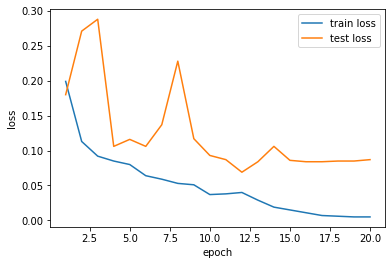

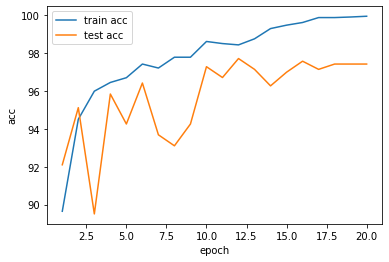

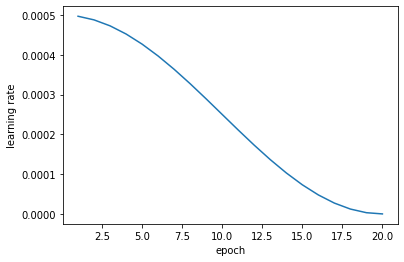

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 21)]

# loss
plt.plot( x, logs['train loss'], label='train loss')
plt.plot( x, logs['test loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()

# acc
plt.plot( x, logs['train acc'], label='train acc')
plt.plot( x, logs['test acc'], label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.clf()

# lr

plt.plot( x, logs['lr'], label='learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

class Baseline(torch.nn.Module):
    
   A deep learning model for Covid-19 detection using X-ray images.
  The model architecture consists of several convolutional layers, pooling layers, dropout layers, and fully connected layers.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        pool (nn.MaxPool2d): The max pooling layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        dropout (nn.Dropout): The dropout layer.
        conv3 (nn.Conv2d): The third convolutional layer.
        fc1 (nn.Linear): The first fully connected layer.
        fc2 (nn.Linear): The second fully connected layer.
        fc3 (nn.Linear): The third fully connected layer.
        fc4 (nn.Linear): The fourth fully connected layer.
        fc5 (nn.Linear): The output layer.

    Methods:
        forward(x): Performs a forward pass through the model to make predictions.

  

In [ ]:
from re import X
import torch.nn.functional as F
class Baseline(torch.nn.Module):
    
    def __init__(self):
        super(Baseline, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 7)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*25*25, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

This code block trains and evaluates the Baseline model on the Covid-19 dataset. It saves the model with the best testing loss.

In [ ]:
# Normal baseline Training

torch.cuda.empty_cache()

net = Baseline().to(device)
opt = torch.optim.Adam(net.parameters(), lr=0.0002)
cri = torch.nn.BCEWithLogitsLoss()
EPOCH = 30

sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCH)
logs = {
    'train loss':[],
    'train acc':[],
    'test loss':[],
    'test acc':[],
    'lr':[]
    }


best_loss = 10000
classify(net, test_loader)

for e in range(EPOCH):

  train_loss, train_acc = train(net, opt, cri, train_loader, e)
  test_loss, test_acc = test(net, cri, test_loader, e)
  logs['train loss'].append(train_loss)
  logs['train acc'].append(train_acc)
  logs['test loss'].append(test_loss)
  logs['test acc'].append(test_acc)
  sch.step()
  logs['lr'].append(sch.get_last_lr()[0])
  if test_loss <= best_loss:
    best_loss = test_loss
    torch.save(net.state_dict(), 'model.pt')


net.load_state_dict(torch.load('model.pt'))
classify(net, test_loader)

100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       613
         pos       0.12      1.00      0.21        83

    accuracy                           0.12       696
   macro avg       0.06      0.50      0.11       696
weighted avg       0.01      0.12      0.03       696



100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

              precision    recall  f1-score   support

         neg       0.98      0.96      0.97       613
         pos       0.76      0.88      0.82        83

    accuracy                           0.95       696
   macro avg       0.87      0.92      0.89       696
weighted avg       0.96      0.95      0.95       696



The accuracies above are the results of Normal Baseline Training.

And codes below plotted the loss, accuracy and the learning rate of this model.

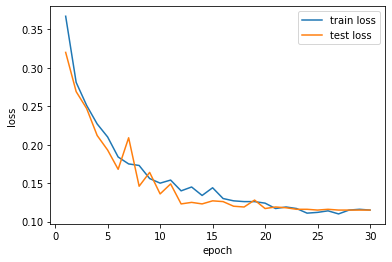

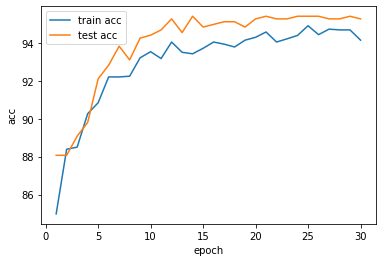

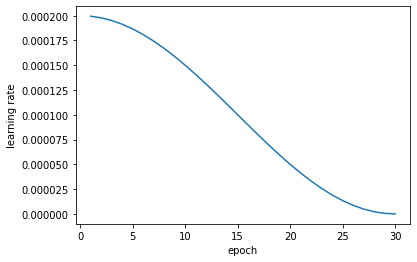

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 31)]

# loss
plt.plot( x, logs['train loss'], label='train loss')
plt.plot( x, logs['test loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()

# acc
plt.plot( x, logs['train acc'], label='train acc')
plt.plot( x, logs['test acc'], label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.clf()

# lr

plt.plot( x, logs['lr'], label='learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()